# ResNet Autoencoder (AE) for ECAL DQM 
EB Occupancy

In [1]:
import numpy as np
np.random.seed(0)
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *

import time
import os, glob
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline

In [15]:
from torch.utils.data import sampler

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)


In [24]:
from matplotlib import colors, cm
hsv = cm.get_cmap('hsv', 12)
binary_cmap = colors.ListedColormap([hsv(0.38), 'red'])

<ipython-input-24-bf2ddd3df84e>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hsv = cm.get_cmap('hsv', 12)


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [4]:
plt.rcParams["figure.figsize"] = (8,6)

def plot_EB(img, vmin=0., vmax=3., cmap='jet', label='Normalized Occupancy', extend_edge=False,typestr='_', t_str='_', epoch=1,norm=None,save=False, cbar=True): # cmap = 'jet'
                  #cmap='gist_yarg
    # Only plots single channel, single sample images
    img = img.squeeze()
    assert len(img.shape) == 2
    
    if extend_edge:
        ieta_max = 18
    else:
        img = img[1:-1,:] if img.shape[-2] > 34 else img
        ieta_max = 17
    
    fig, ax = plt.subplots()
    im = ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    if cbar==True:
        ax.figure.colorbar(im, ax=ax, fraction=0.0228, pad=0.015, label=label)

    # By default, imshow() places tick marks at center of image pixel, 
    # so need to shift to the low side by 0.5 to match DQM convention
    # of ticks being placed on low edge of bin
    off = 0.5
    # Set image coordinates where ticks should appear...
    ax.set_xticks(np.arange(0,72+8,8)-off)
    ax.set_yticks(np.arange(0,(2*ieta_max)+ieta_max,ieta_max)-off)
    # then set what values should be displayed at these coordinates
    ax.set_xticklabels(np.arange(0,72+8,8))
    ax.set_yticklabels([-ieta_max,0,ieta_max])
    # Make ticks face inward
    ax.xaxis.set_tick_params(direction='in', which='major', length=6.,labelsize=10)
    ax.xaxis.set_tick_params(direction='in', which='minor', length=3.,labelsize=10)
    ax.yaxis.set_tick_params(direction='in', which='major', length=6.,labelsize=10)
    ax.yaxis.set_tick_params(direction='in', which='minor', length=3.,labelsize=10)

    # Plot supermodule boundaries. Need to apply same offset for plot()
    # Horizontal +/- eta boundary
    ax.plot([0-off,72-off],[ieta_max-off,ieta_max-off], linewidth=1., linestyle='--', color='black')
    # Vertical phi boundaries
    for iphi in np.arange(0,72,4):
        ax.plot([iphi-off,iphi-off],[0-off,(2*ieta_max)-off], linewidth=1., linestyle='--', color='black')
    plt.xlabel(r'$\mathrm{i\varphi_{tow}}$', size=16)
    plt.ylabel(r'$\mathrm{i\eta_{tow}}$', size=16)
    if save==True:
        plt.savefig('%s.png' %t_str, bbox_inches='tight')

    plt.show()
    plt.close()

In [5]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    print(a.shape,sh)
    return a.reshape(sh).sum(-1).sum(1)

required group field_id=-1 schema {
  optional group field_id=-1 EBIntegrityClient_EBIT_channel_status_map (List) {
    repeated group field_id=-1 list {
      optional group field_id=-1 item (List) {
        repeated group field_id=-1 list {
          optional double field_id=-1 item;
        }
      }
    }
  }
}

  created_by: parquet-cpp version 1.3.1-SNAPSHOT
  num_columns: 1
  num_rows: 1
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 304
(170, 360)
(170, 360) (34, 5, 72, 5)
(34, 72)
25.0
1.0


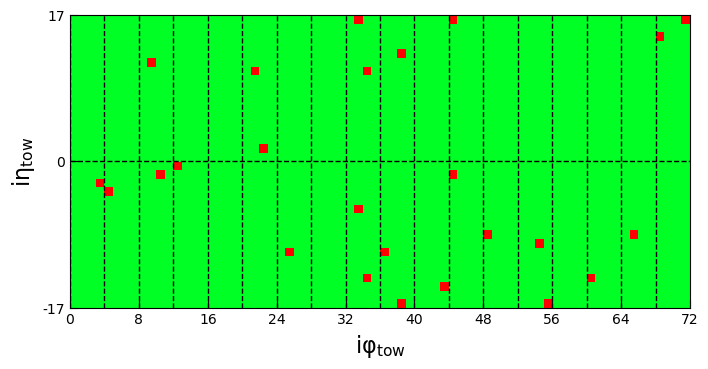

In [6]:
#Get channel status map to identify masked towers
f = pq.ParquetFile('Good_parquet/run325170_channel_status.parquet')
print(f.schema)
print(f.metadata)

d2 = np.array(f.read_row_group(0).to_pydict()['EBIntegrityClient_EBIT_channel_status_map'])
d2=d2.reshape(170,360)
print(d2.shape)
d2_=d2.copy()
d2_[d2_> 0]=1
d2_[d2_<=0]=0

#Rebin to tower level (5x5 crystals)
shape=[34, 72]
reb_d2=rebin(d2_,shape)

ch_status = reb_d2.copy()

print(ch_status.shape)
print(ch_status.max())
ch_status[ch_status <= 5. ] =0.
ch_status[ch_status > 5. ] = 1.
print(ch_status.max())


plot_EB(ch_status,vmin=0,vmax=1, cmap=binary_cmap, cbar=False, label='Channel Status Map')

## Define pre-processing routine

In [43]:
fit = np.loadtxt('PU_corr_EB_2018.txt')


In [44]:
def apply_PU_corr(img,pu):
    '''
    Function to correct occupancy for PU
    '''
    img = img/(fit[0]*pu + fit[1])
    img *= 34*72 #scale up to original dimensions
    return img

# Define input datasets

Define how "good" samples are to be read in

In [8]:
class ParquetDataset(Dataset):
    '''
    Define Dataset class for "good" samples.
    Occ vs PU correction to be applied here to obtain a normalized occupancy as a fn of PU
    '''
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        #self.cols = None # read all columns
        self.cols = ['EBOccupancyTask_EBOT_digi_occupancy.list.item.list.item','PU']
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.float32(data['EBOccupancyTask_EBOT_digi_occupancy'][0]).reshape(-1,34,72)
        data['PU']= np.float32(data['PU'][0])
        data['EBOccupancyTask_EBOT_digi_occupancy'] = apply_PU_corr(data['EBOccupancyTask_EBOT_digi_occupancy'], data['PU'])
        data['index'] = index
        #Edges are padded to mitigate the "edge effect" of suboptimal learning at the boundaries
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.pad(data['EBOccupancyTask_EBOT_digi_occupancy'], ((0,0), (1,1), (0,0)), 'edge')
       
        return (data)

    def __len__(self):
        return self.parquet.num_row_groups

Split data into training, validation, and anomaly sets

In [29]:
input_runs = glob.glob('Good_parquet/500ev_ECALDQM_run*.parquet')
print('>> N input runs: %s'%len(input_runs))
assert len(input_runs) > 0

# Split input "good" dataset into training and validation sets
dset_good = ConcatDataset([ParquetDataset('%s'%r) for r in input_runs])
print('>> N good samples:',len(dset_good))
n_train, n_val= 91936,10000,
#n_train, n_val= 10000,1000
n_train, n_val = int(n_train), int(n_val)#, int(n_test)
print('>> N train samples:',n_train)
print('>> N val samples:',n_val)
#print('>> N test samples:',n_test)
assert n_train+n_val <= len(dset_good)
# Shuffle indices before making split
# Files may be ordered by run or LS which should not be learned
idxs = np.random.permutation(len(dset_good))
idxs_train, idxs_val = idxs[:n_train], idxs[-n_val:]

# Training set needs to be shuffled
sampler_train = sampler.SubsetRandomSampler(idxs_train)
loader_train = DataLoader(dataset=dset_good, batch_size=32, num_workers=10, sampler=sampler_train, pin_memory=True)

# Do not shuffle validation set so can compare same image from epoch to epoch
sampler_val = sampler.SequentialSampler(idxs[-n_val:])
loader_val = DataLoader(dataset=dset_good, batch_size=32, num_workers=10, sampler=sampler_val)

#sampler_test = sampler.SequentialSampler(idxs[-n_test:])
#loader_test = DataLoader(dataset=dset_good, batch_size=32, num_workers=10, sampler=sampler_test)


>> N input runs: 205
>> N good samples: 101936
>> N train samples: 10000
>> N val samples: 1000


--

--

In [9]:
avg_occ=np.loadtxt('avgocc.txt')
avg_loss=np.loadtxt('avgloss.txt')
avg_reco=np.loadtxt('avgreco.txt')

In [11]:
#convert avg occ to tensor
avg_reco_T=torch.from_numpy(avg_reco).float().cuda()
avg_occ_T=torch.from_numpy(avg_occ).float().cuda()

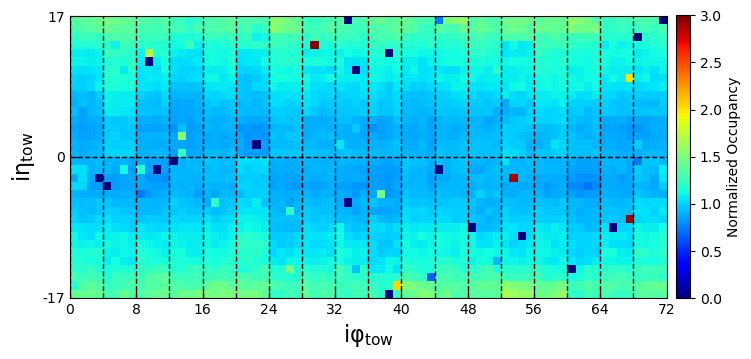

In [10]:
plot_EB(avg_occ,t_str='Occupancy', vmax=3., cmap='jet')

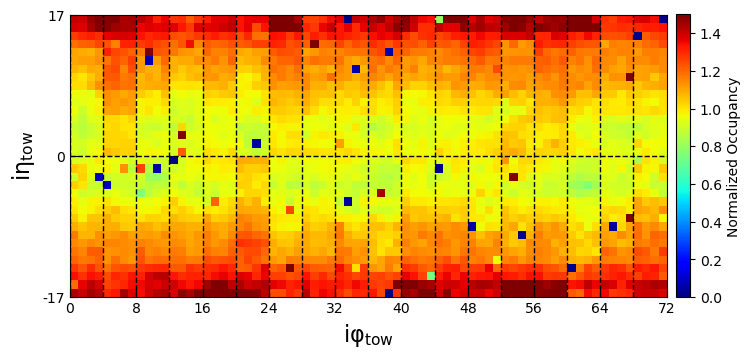

In [12]:
plot_EB(avg_reco,vmax=1.5,t_str='Reco')

In [ ]:
plot_EB(avg_loss,vmin=avg_loss.min(), vmax=avg_loss.max(), t_str='Loss_log_50ep')
print(avg_loss.min(),avg_loss.max())

#  AE model


Define ResNet blocks for encoding and decoding

In [19]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        #self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=0)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        #self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample, padding=0)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

Define the full ResNet autoencoder module

In [20]:
class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        #3x3, s=1, down4/5
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=3, stride=1, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        self.elayer4 = self.block_layers(1, [fmaps[1],fmaps[2]], 'enc')
        self.elayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[-1], self.fmaps[-1]*5*9) # 5x5
        self.dlayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'dec', out_shape=None)
        self.dlayer4 = self.block_layers(1, [fmaps[2],fmaps[1]], 'dec', out_shape=(9,18))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(18,36))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        #self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=7, stride=2, padding=(0,1))
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=3, stride=1, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)


    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size())
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size())

        x = self.elayer1(x)
        if self.debug: print(x.size())
        x = self.elayer2(x)
        if self.debug: print(x.size())
        x = self.elayer3(x)
        if self.debug: print(x.size()) #32x9x18
        x = self.elayer4(x)
        if self.debug: print(x.size())
        x = self.elayer5(x)
        if self.debug: print(x.size())
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Maxpool-FC")
        x = F.max_pool2d(x, kernel_size=x.size()[2:]) #32x9x18 -> 32x1 : Global max of each map.
        if self.debug: print(x.size())
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size())
        
        
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        x = self.fc(x) # expand   #32x1->FCN
        if self.debug: print(x.size())
        #x = x.view(-1, self.fmaps[1], 4, 9) # 7x7, s=2
        #x = x.view(-1, self.fmaps[1], 9, 18) # 5x5 or 3x3, s=1  #restructure back to 32x9x18
        x = x.view(-1, self.fmaps[-1], 5, 9) # 3x3, down4/5
        if self.debug: print(x.size())        
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer5(x)
        if self.debug: print(x.size())
        x = self.dlayer4(x)
        if self.debug: print(x.size())
        x = self.dlayer3(x)
        if self.debug: print(x.size())
        x = self.dlayer2(x)
        if self.debug: print(x.size())
        x = self.dlayer1(x)
        if self.debug: print(x.size())
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size())
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, 2+170//5, 360//5))
        if self.debug: print(x.size())
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

# Evaluation function

Define what to do during the validation phase of the training. For instance, we can look at the original and AE-reconstructed image for some fixed sample at every epoch, and observe how the AE loss map between them changes during training.

In [28]:
def do_eval(ae, val_loader, epoch, dstr='EBOccupancyTask_EBOT_digi_occupancy', idx=0, typestr='_'):
    loss_ = []
    now = time.time()
    for i, data in enumerate(val_loader):
        X = data[dstr].cuda()
        Xreco = ae(X)
        #Padding removed during evaluation
        X, Xreco = X[...,1:-1,:], Xreco[...,1:-1,:]
        
        # By default, torch.mse_loss takes batch-averaged loss
        # During validation phase, want to know EB loss map for each sample (LS) in the batch
        # reduction='none' calculates loss on each *pixel* in image
        losses = F.mse_loss(Xreco, X, reduction='none')
        losses = losses.view(losses.size()[0],-1).mean(dim=-1) # For calculating single loss per sample in batch
        loss_.append(losses.tolist())
        # To monitor progress from epoch to epoch, 
        # explicity plot original and AE-reconstructed images for idx-th sample in the first batch
        # then plot the loss map
        
        if i == 0:  
            # Original image:
            print(' >> original image:')
            img = X[idx].cpu().numpy()
            #plot_EB(img, cmap='jet', typestr=typestr, t_str='orig', epoch=epoch)
            # AE-reconstructed image
            print(' >> AE-reco image:')
            img_reco = Xreco[idx].detach().cpu().numpy()
            #plot_EB(img_reco, cmap='jet',typestr=typestr, t_str='AEreco', epoch=epoch)
            # Loss map
            print(' >> loss map:')
            img_loss = F.mse_loss(Xreco[idx], X[idx], reduction='none').detach().cpu().numpy()    
            #plot_EB(img_loss, vmax=img_loss.max(), cmap='jet', label='Loss Map', typestr=typestr, t_str='loss', epoch=epoch)    

    now = time.time() - now
    loss_ = np.concatenate(loss_)
    model_name= 'resnetAE_EBOcc_epoch%d' %epoch
    filename = 'MODELS/ResNet_3_16_32_64_epoch100/model_%s_%s_loss=%f.pkl'%(typestr, model_name ,loss_.mean() )
    model_dict = {'model': ae.state_dict(), 'optim': optimizer.state_dict()}
    torch.save(model_dict, filename)
    s = '%d: Val loss:%f, MAE: %f, N samples: %d in %f min'%(epoch, loss_.mean(), (np.sqrt(loss_)).mean(), len(loss_), now/60.)
    print(s)
    return loss_.mean()


# Auto-encoder Training Loop



>> Epoch 1 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


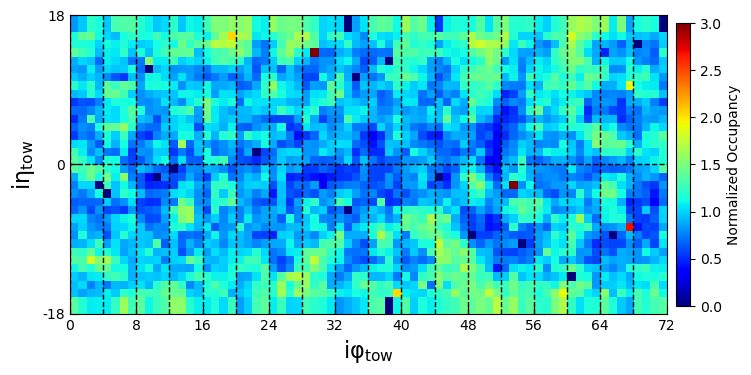

 >> AE-reco image:


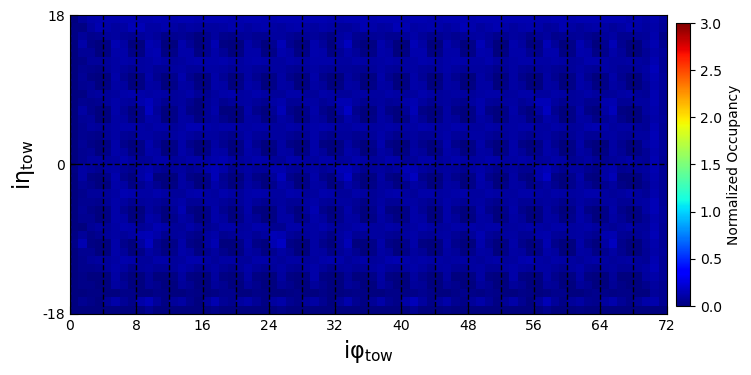

 >> loss map:


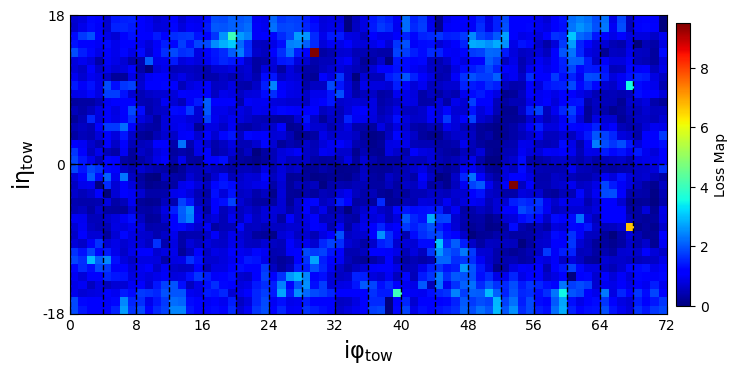

1: (0/313) Train loss:0.990963, Emax: 3.205643, Erecomax: 0.180146
1: Train time:0.31 min in 313 steps
>> Validation: Good samples <<<<<<<<
 >> original image:
 >> AE-reco image:
 >> loss map:
1: Val loss:0.044007, MAE: 0.208839, N samples: 1000 in 0.029243 min
>> Epoch 2 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


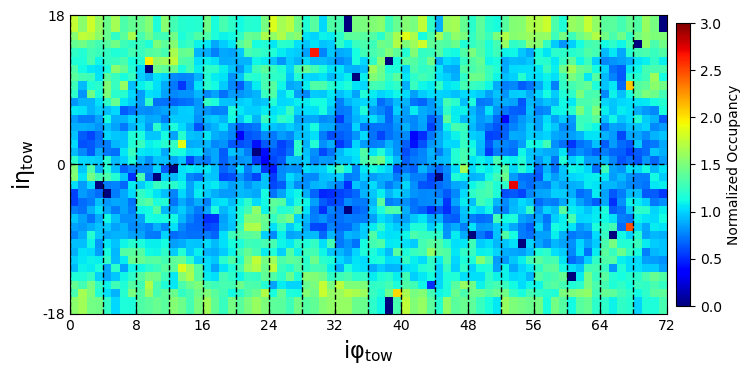

 >> AE-reco image:


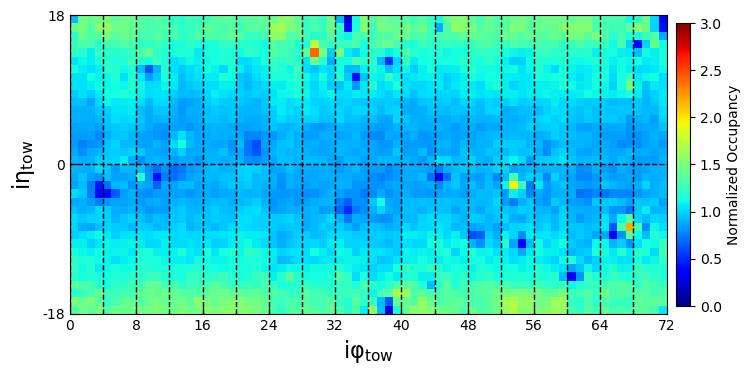

 >> loss map:


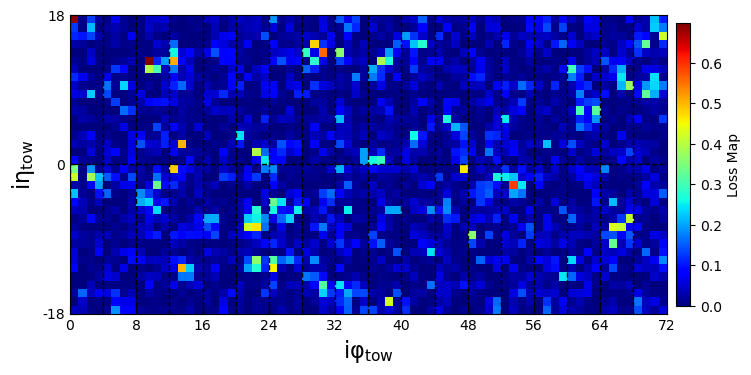

2: (0/313) Train loss:0.044160, Emax: 2.719033, Erecomax: 2.397872
2: Train time:0.28 min in 313 steps
>> Validation: Good samples <<<<<<<<
 >> original image:
 >> AE-reco image:
 >> loss map:
2: Val loss:0.041600, MAE: 0.203317, N samples: 1000 in 0.024329 min
>> Epoch 3 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


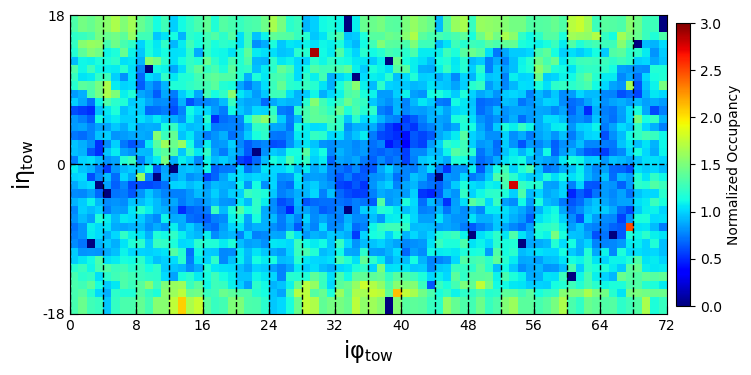

 >> AE-reco image:


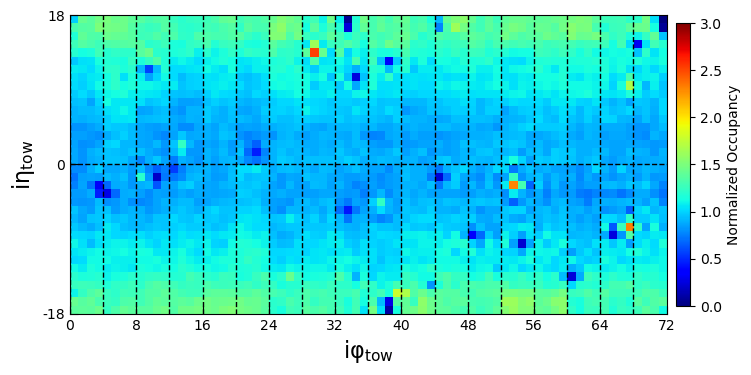

 >> loss map:


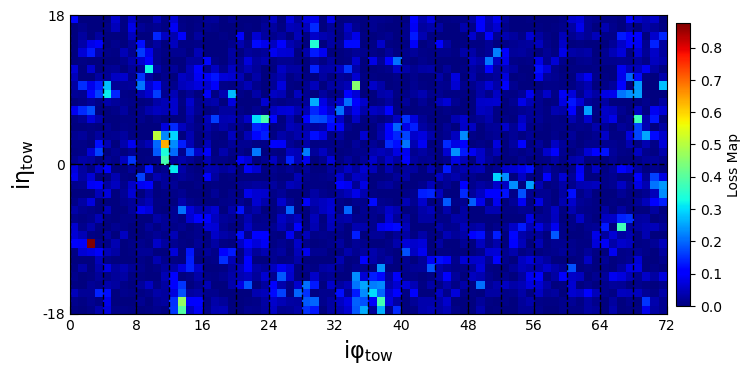

3: (0/313) Train loss:0.044555, Emax: 2.885866, Erecomax: 2.522125
3: Train time:0.21 min in 313 steps
>> Validation: Good samples <<<<<<<<
 >> original image:
 >> AE-reco image:
 >> loss map:
3: Val loss:0.040397, MAE: 0.200440, N samples: 1000 in 0.026893 min


In [39]:
# Initialize AE model
ae = ResNetAE(1, 3, [16, 32, 64]) 
ae.cuda()
# Initialize optimizer
optimizer = optim.Adam(ae.parameters(), lr=5.e-4)
train_loss, val_loss =[], []
epochs = 3
monitor_step = 2000
for e in range(epochs):

    epoch = e+1
    s = '>> Epoch %d <<<<<<<<'%(epoch)
    print(s)

    # Run training
    ae.train()
    print(">> Training <<<<<<<<")
    now = time.time()
    tloss=[]
    for i, data in enumerate(loader_train):
        X = data['EBOccupancyTask_EBOT_digi_occupancy'].cuda()
        # Reset gradient at each batch
        optimizer.zero_grad()
        # AE-reconstructed images
        Xreco = ae(X)
        # Batch-averaged loss
        loss = F.mse_loss(Xreco, X)
    
        tloss.append(loss.item())
        # Calculate backprop errors
        loss.backward()
        # Update network weights
        optimizer.step()
        # To monitor training progress during the epoch
        # explicity plot original and AE-reconstructed images for 0-th sample in every monitor_step batch
        # then plot the loss map
        if i % monitor_step == 0:
            # Original image:
            print(' >> original image:')
            img = X[0].cpu().numpy()
            plot_EB(img, extend_edge=True)
            # AE-reconstructed image
            print(' >> AE-reco image:')
            img_reco = Xreco[0].detach().cpu().numpy()
            plot_EB(img_reco, extend_edge=True)
            # Loss map
            print(' >> loss map:')
            img_loss = F.mse_loss(Xreco[0], X[0], reduction='none').detach().cpu().numpy()
            plot_EB(img_loss, vmax=img_loss.max(), cmap='jet', label='Loss Map', extend_edge=True)
            print('%d: (%d/%d) Train loss:%f, Emax: %f, Erecomax: %f'%(epoch, i, len(loader_train), loss.item(), img.max(), img_reco.max()))
        #break
    train_loss.append(np.mean(tloss))
    now = time.time() - now
    s = '%d: Train time:%.2f min in %d steps'%(epoch, now/60, len(loader_train))
    print(s)
    #'''
    # Run Validation
    ae.eval()
    print(">> Validation: Good samples <<<<<<<<")
    vloss = do_eval(ae, loader_val, epoch)
    #print(vloss)
    val_loss.append(vloss)
    

In [40]:
len(train_loss)


3

End of Training